We will compare the CNN and FNO to test their performance compared to each other, the tests we will perform:
1. Accuracy as a function of number of epochs.
2. Accuracy as a number of data size.
3. Model performance of a data in which a sensor is malfunctioning.
4. Accuracy as a function of noise std added to the data.

First we will provide the helper functions to visualize and test the results, as well as data generation functions.

In [2]:
import random
from CNN_Student import WaveToMapNet, train_student
from FNO import LearnableBasisNet_Simple, train_fno
from CNN_Teacher import TeacherWaveToMapNet, train_teacher
from data_utilities import *
from testing import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
random.seed(42)

Now we will start with the first test : Testing accuracy as a function of number of epochs. This simulates a case where you need to decide which model to use for this task when you have limited computational resources.

Data generation parameters, where the chosen parameters for the experiment are determined

In [3]:
# data params
num_samples = 5000
grid_size = 32
noise_level = 0.001 # noise that will be added on generation to all data, we add more noise during training to the FNO and CNN models
dropout_prob = 0 # probability that a sensor is dropped in a single data simple
two_source_input_prob = 0 # probability that a sample will be a two source sample, rather than a one source sample
time_steps = 200

# data physical parameters
wave_freq = 5.0 # [Hz]
sigma = 3.0 # gaussian std

# velocity is generated randomly (uniform dist) between the min and max values below
min_vel = 280.0 # [meters / seconds]
max_vel = 320.0 # [meters / seconds]

We will now generate the data for the first experiment

In [4]:
train_loader, val_loader, test_loader = create_data_and_data_loaders(num_samples, grid_size, noise_level, dropout_prob, min_vel, max_vel, two_source_input_prob, wave_freq, time_steps, sigma)

Choose the desired number of epochs to test, either way, the teacher will be trained for 30 epochs

In [5]:
total_epochs = 40

In [ ]:
teacher = TeacherWaveToMapNet().to(device)
train_teacher(teacher, train_loader, val_loader, epochs=30)

Teacher Epoch 5/30 | Loss: 0.002425
Teacher Epoch 10/30 | Loss: 0.001759
Teacher Epoch 15/30 | Loss: 0.001564
Teacher Epoch 20/30 | Loss: 0.001516
Teacher Epoch 25/30 | Loss: 0.001326
Teacher Epoch 30/30 | Loss: 0.001255
Training complete, Validating now
Teacher Validation Loss: 0.001259


In [ ]:
cnn = WaveToMapNet().to(device)
cnn_history = train_student(cnn, teacher, train_loader, val_loader, test_loader, total_epochs)

Distill Epoch 5/40 | Loss: 0.004699
Distill Epoch 10/40 | Loss: 0.001207
Distill Epoch 15/40 | Loss: 0.000743
Distill Epoch 20/40 | Loss: 0.000579
Distill Epoch 25/40 | Loss: 0.000497
Distill Epoch 30/40 | Loss: 0.000367
Distill Epoch 35/40 | Loss: 0.000243
Distill Epoch 40/40 | Loss: 0.000128
Student Validation Loss: 0.001227


In [6]:
fno = LearnableBasisNet_Simple().to(device)
fno_history = train_fno(fno, train_loader, val_loader, test_loader, total_epochs)

FNO Epoch 5/40 | Loss: 0.002975
FNO Epoch 10/40 | Loss: 0.002353
FNO Epoch 15/40 | Loss: 0.001883
FNO Epoch 20/40 | Loss: 0.001472
FNO Epoch 25/40 | Loss: 0.001265
FNO Epoch 30/40 | Loss: 0.001100
FNO Epoch 35/40 | Loss: 0.001015
FNO Epoch 40/40 | Loss: 0.001073


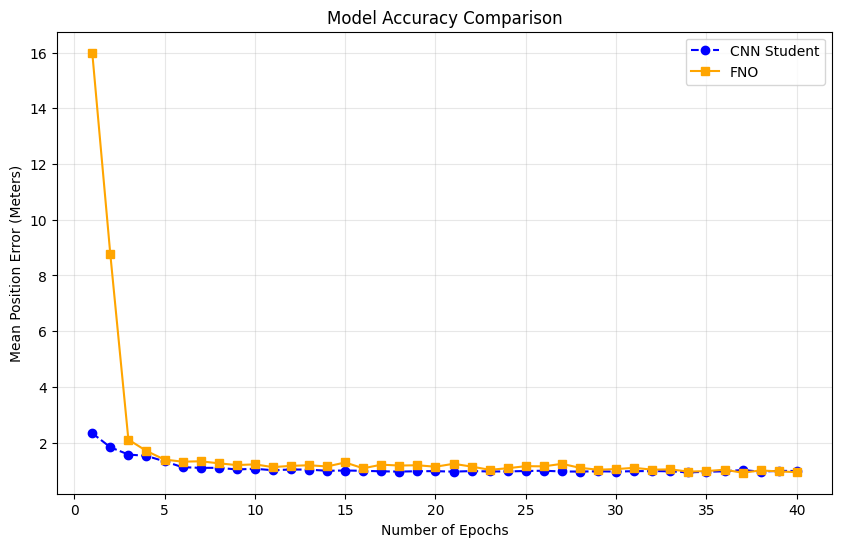

In [ ]:
plot_results(cnn_history, fno_history)

As we can see, the CNN student starts with very low error even for a small number of epochs, this is because it has the guidance of the teacher model. The FNO, even without a Teacher, quickly reaches similar accuracy as the CNN student.

In [ ]:
cnn_best_epoch, cnn_lowest = get_min_and_index(cnn_history)
fno_best_epoch, fno_lowest = get_min_and_index(fno_history)

print(f"CNN best epoch was {cnn_best_epoch} with a lowest error of {cnn_lowest} meters")
print(f"FNO best epoch was {fno_best_epoch} with a lowest error of {fno_lowest} meters")

CNN best epoch was 28 with a lowest error of 0.8649185087173562
FNO best epoch was 38 with a lowest error of 0.8906879180332015


We can see the size and number of params of each model, it is impressive that the FNO is able to deal achieve similar results to the CNN even with way less parameters, this is due to it Utilizing the Math and Physics of the Frequency domain for this given problem.

In [ ]:
teacher_size, teacher_params = get_model_size_and_n_params(teacher, "Teacher Model")
print("=" * 50)
CNN_size, CNN_params = get_model_size_and_n_params(cnn, "CNN Student Model")
print("=" * 50)
FNO_size, FNO_params = get_model_size_and_n_params(fno, "FNO Model")

Teacher Model size: 801.25 MB
number of trainable params: 210040897
CNN Student Model size: 100.98 MB
number of trainable params: 26469505
FNO Model size: 28.13 MB
number of trainable params: 7375232


In [ ]:
print(f"ratio between CNN and FNO params is {CNN_params / FNO_params}")
print(f"ratio between CNN and FNO size is {CNN_size / FNO_size}")

ratio between CNN and FNO params is 3.5910915657289224
ratio between CNN and FNO size is 3.5912063417122515


Moving on to the 2nd test: Accuracy as a function of the size of the data.

For each amount of samples we will re-train both models (CNN student, FNO), this will simulate a case in which you have different amounts of data to train the models with

Here you can modify the sample sized which will be tested

In [ ]:
chosen_sample_sizes = [1000, 2000, 3000, 5000, 10000]
chosen_epochs = 15 # number of epochs each model will be trained on the given dataset size
two_source_input_prob = 0 # probability that a sample will have 2 sources (default is 1)

Setup the 2nd test and run it

In [ ]:
train_pool, val_dataset, test_tensors = setup_global_experiment(total_samples=int(np.round(chosen_sample_sizes[-1] * 1.2)), two_source_input_prob=two_source_input_prob)

In [ ]:
results = run_efficiency_experiments(train_pool, val_dataset, test_tensors, sample_sizes = chosen_sample_sizes, epochs=chosen_epochs)


Training Global Teacher (Oracle)
Teacher Epoch 5/15 | Loss: 0.001677
Teacher Epoch 10/15 | Loss: 0.001412
Teacher Epoch 15/15 | Loss: 0.001255
Training complete, Validating now
Teacher Validation Loss: 0.001582

Experiment: Subset Size = 1000
Training CNN Student (Distilled from Oracle)...
Distill Epoch 5/15 | Loss: 0.028275
Distill Epoch 10/15 | Loss: 0.009395
Distill Epoch 15/15 | Loss: 0.004287
Student Validation Loss: 0.007525
Training FNO...
FNO Epoch 5/15 | Loss: 0.024871
FNO Epoch 10/15 | Loss: 0.024859
FNO Epoch 15/15 | Loss: 0.022583

Experiment: Subset Size = 2000
Training CNN Student (Distilled from Oracle)...
Distill Epoch 5/15 | Loss: 0.010641
Distill Epoch 10/15 | Loss: 0.002970
Distill Epoch 15/15 | Loss: 0.001302
Student Validation Loss: 0.004771
Training FNO...
FNO Epoch 5/15 | Loss: 0.023438
FNO Epoch 10/15 | Loss: 0.022585
FNO Epoch 15/15 | Loss: 0.019649

Experiment: Subset Size = 3000
Training CNN Student (Distilled from Oracle)...
Distill Epoch 5/15 | Loss: 0.009

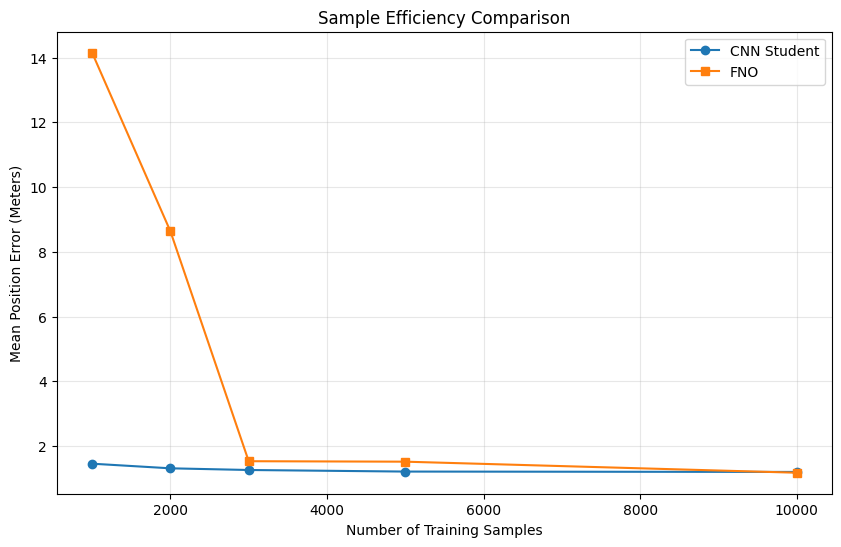

In [ ]:
plot_sample_efficiency(results)

Similar to the previous test, we can see that for low amounts of data, the CNN student outperforms the FNO since it has the guidance of the teacher model, but soon the FNO catches up and achieves a similar error rate.

We will now perform the third test - testing the performance of both models when a sensor is malfunctioning

We will check what happens when you train your models on clean data, but then in the "money-time" one of the sensors is malfunctioning, meaning it provides no data at all or very noisy data

Choose which sensor to fail and the number of epochs the models will train

In [ ]:
chosen_epochs_2 = 20 
sensor_index = 1 # should be one of 0,1,2,3
total_samples_2 = 5000

Setting up and running the third experiment

In [ ]:
acc_cnn_clean, acc_cnn_broken, acc_fno_clean, acc_fno_broken = run_sensor_malfunction_experiment(total_samples = total_samples_2, epochs=chosen_epochs_2, sensor_idx=sensor_index)


Running Sensor Malfunction Robustness Test
Training models on clean data
Teacher Epoch 5/20 | Loss: 0.002067
Teacher Epoch 10/20 | Loss: 0.001455
Teacher Epoch 15/20 | Loss: 0.001293
Teacher Epoch 20/20 | Loss: 0.001269
Training complete, Validating now
Teacher Validation Loss: 0.001510
Teacher Trained
Distill Epoch 5/20 | Loss: 0.003240
Distill Epoch 10/20 | Loss: 0.001173
Distill Epoch 15/20 | Loss: 0.000669
Distill Epoch 20/20 | Loss: 0.000323
Student Validation Loss: 0.001259
CNN Student Trained
FNO Epoch 5/20 | Loss: 0.002629
FNO Epoch 10/20 | Loss: 0.002350
FNO Epoch 15/20 | Loss: 0.001774
FNO Epoch 20/20 | Loss: 0.001334
 FNO Trained

 Generating Malfunction Test Set (Sensor 1 -> Dead/Noisy)...

 Evaluating...

Results Summary:
CNN | Clean Error: 0.87m | Broken Sensor Error: 3.58m
FNO | Clean Error: 0.99m | Broken Sensor Error: 2.89m


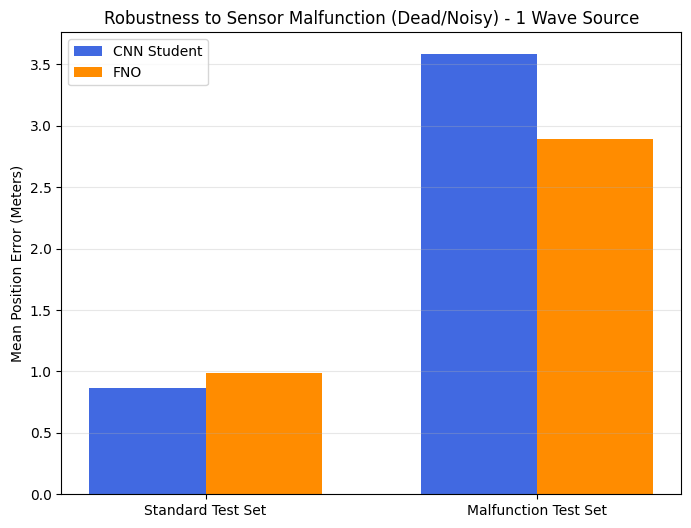

In [ ]:
plot_robustness_comparison(acc_cnn_clean, acc_cnn_broken, acc_fno_clean, acc_fno_broken)

We can see that the FNO actually performs better when dealing with a malfunctioning sensor, essentially being more robust to this hard challenge.

Now we will perform the 4th tests which tests the performance of each model based on the level of noise the data contains

Generating Base Physics (5000 samples)...
Starting Noise Robustness Test
Testing Noise Level: 0.0... Done. (CNN: 1.06m | FNO: 1.04m)
Testing Noise Level: 0.005... Done. (CNN: 1.06m | FNO: 1.04m)
Testing Noise Level: 0.01... Done. (CNN: 1.06m | FNO: 1.04m)
Testing Noise Level: 0.05... Done. (CNN: 1.15m | FNO: 1.15m)
Testing Noise Level: 0.1... Done. (CNN: 1.34m | FNO: 1.40m)


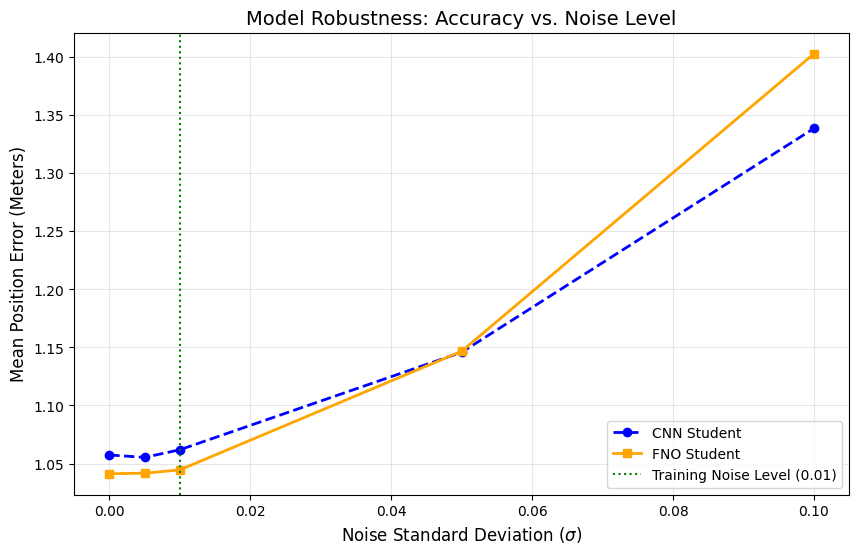

In [ ]:
# run test
noise_results = run_noise_robustness_test(cnn, fno, num_samples=5000)

# plot the results
plot_noise_robustness(noise_results, noise_level=0.001)